<a href="https://colab.research.google.com/github/AndreasTrupin/DST/blob/main/e_Compy_Modelisation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages et des datasets

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mlp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import des données
events = pd.read_csv('events.csv')


In [ ]:
## NE PAS GARDER DANS LE CODE FINAL
# Au cas où erreur sur le df events: reloader avec cette cellule
events = pd.read_csv('events.csv')

In [ ]:
# Décomposer la date en année, mois, jour et heure. A voir pour une exploitation future dans la table event
events['heure_event']= pd.to_datetime(events['timestamp'], unit = 'ms')
events['jour'] = events['heure_event'] .dt.day
events['mois'] = events['heure_event'] .dt.month
events['annee'] = events['heure_event'] .dt.year
events['heure'] = events['heure_event'] .dt.hour
events.head()

,timestamp,visitorid,event,itemid,transactionid,heure_event,jour,mois,annee,heure
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2,6,2015,5
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2,6,2015,5
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2,6,2015,5
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2,6,2015,5
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2,6,2015,5


# **Modèle : Clustering des produits**

In [ ]:
events.head(10)

,timestamp,visitorid,event,itemid,transactionid,heure_event,jour,mois,annee,heure
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2,6,2015,5
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2,6,2015,5
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2,6,2015,5
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2,6,2015,5
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2,6,2015,5
5,1433224086234,972639,view,22556,NaN,2015-06-02 05:48:06.234,2,6,2015,5
6,1433221923240,810725,view,443030,NaN,2015-06-02 05:12:03.240,2,6,2015,5
7,1433223291897,794181,view,439202,NaN,2015-06-02 05:34:51.897,2,6,2015,5
8,1433220899221,824915,view,428805,NaN,2015-06-02 04:54:59.221,2,6,2015,4
9,1433221204592,339335,view,82389,NaN,2015-06-02 05:00:04.592,2,6,2015,5


In [ ]:
# les colonnes à supprimer :
#>> timestamp et heure event : car elles sont décomposées dans d'autres colonnes

events.drop(['timestamp', 'heure_event'], axis=1, inplace=True)
events.head()

,visitorid,event,itemid,transactionid,jour,mois,annee,heure
0,257597,view,355908,NaN,2,6,2015,5
1,992329,view,248676,NaN,2,6,2015,5
2,111016,view,318965,NaN,2,6,2015,5
3,483717,view,253185,NaN,2,6,2015,5
4,951259,view,367447,NaN,2,6,2015,5


In [ ]:
#Création d'un sub dataframe avec les colonnes à utiliser dans le cadre de l'hypothèse clustering
subevents = events[["visitorid","itemid", "event","transactionid","heure"]]
subevents.head()

,visitorid,itemid,event,transactionid,heure
0,257597,355908,view,NaN,5
1,992329,248676,view,NaN,5
2,111016,318965,view,NaN,5
3,483717,253185,view,NaN,5
4,951259,367447,view,NaN,5


In [ ]:
subevents_type = subevents.join(pd.get_dummies(events['event'], prefix='event'))
subevents_type.head(10)

,visitorid,itemid,event,transactionid,heure,event_addtocart,event_transaction,event_view
0,257597,355908,view,NaN,5,0,0,1
1,992329,248676,view,NaN,5,0,0,1
2,111016,318965,view,NaN,5,0,0,1
3,483717,253185,view,NaN,5,0,0,1
4,951259,367447,view,NaN,5,0,0,1
5,972639,22556,view,NaN,5,0,0,1
6,810725,443030,view,NaN,5,0,0,1
7,794181,439202,view,NaN,5,0,0,1
8,824915,428805,view,NaN,4,0,0,1
9,339335,82389,view,NaN,5,0,0,1


In [ ]:
## NE PAS METTRE DANS LE CODE FINAL / Répétition du df ci-dessus

# génération du df avec les classes de event
subevent3=subevents_type[["visitorid","itemid","heure","transactionid","event_addtocart","event_transaction","event_view"]]

In [ ]:
# comptabilisation des events par visiteur
Profil_visiteur = subevents_type.groupby('visitorid').agg({'event_addtocart': 'sum',
                                                      'event_transaction': 'sum',
                                                      'event_view': 'sum',}).astype('int')
Profil_visiteur


,event_addtocart,event_transaction,event_view
visitorid,,,
0,0,0,3
1,0,0,1
2,0,0,8
3,0,0,1
4,0,0,1
...,...,...,...
1407575,0,0,1
1407576,0,0,1
1407577,0,0,1


In [ ]:
# comptabilisation des events par produit jusqu'à l'acte d'achat

Profil_produit = subevents_type.groupby('itemid').agg({'event_addtocart': 'sum',
                                                 'event_transaction': 'sum',
                                                 'event_view': 'sum', 
                                                 'visitorid': 'count'}).astype('int') # Nous permet d'avoir le total de visiteurs ayant fait une action sur l'item
Profil_produit

,event_addtocart,event_transaction,event_view,visitorid
itemid,,,,
3,0,0,2,2
4,0,0,3,3
6,0,0,29,29
9,0,0,2,2
15,3,1,18,22
...,...,...,...,...
466861,5,1,89,95
466862,0,0,4,4
466863,0,0,1,1


Nous ajoutons ensuite une variable qui - **le taux d'achat**:
Il s'agit du ratio obtenu par le nombre de transactions divisé par le nombre de visites sur ce produit.

In [ ]:
# Pour ce faire, nous rajoutons une colonne au subset Profil_produit

#Profil_produit['taux_achat'] = (Profil_produit['event_transaction']/Profil_produit['visitorid']*100).round(2)
P#rofil_produit.head()

In [ ]:
# A partir du Profil_produit filtrons à présent les lignes pour lesquelles il y a eu une transaction

Profil_transaction = Profil_produit[Profil_produit.event_transaction>=1].sort_values(by='event_transaction', ascending=False)
Profil_transaction.head()

,event_addtocart,event_transaction,event_view,visitorid
itemid,,,,
461686,306,133,2539,2978
119736,44,97,752,893
213834,17,92,293,402
312728,162,46,947,1155
7943,97,46,1346,1489


On recupère ici toutes les lignes ayant fait l'objet de transactions. 
Attention dans ce rendu un item peut avoir été acheté plusieurs fois par un visiteur. En effet, comme vu plus haut le 
nombre de visiteurs uniques est de 17673. 

>> ## CI-DESSOUS garde-t-on la classification du taux d'achat puisque la modélisation est un clustering et non une prédiction de classe ? 


In [ ]:
# il faut à présent définir une colonne avec une classes de produit à partir du taux d'achat

#Profil_transaction['Classe'] = Profil_transaction['taux_achat'].apply(lambda x : "Faible" if x<=0.25 else "Moyenne" if x<=75 else "Forte" )
#Profil_transaction.head()

In [ ]:
# vérification de l'affectation aux classes
#Profil_transaction['Classe'].unique()

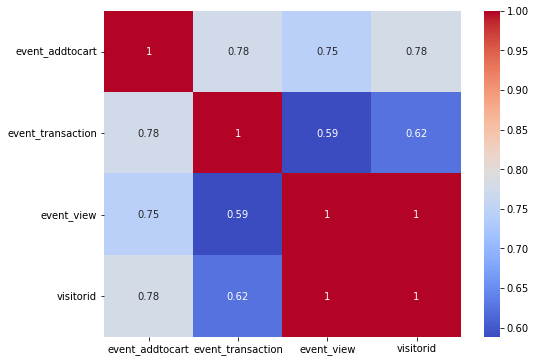

In [ ]:
# Relation entre les variables

cor = Profil_transaction.corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cor, annot=True, ax=ax, cmap='coolwarm');

Nous avons la confirmation qu'il existe une relation de linearite entre le nb de produits mis dans le panier et la transaction realisee par la suite

# 1. Clustering des produits

### Relation entre les variables et représentation graphique


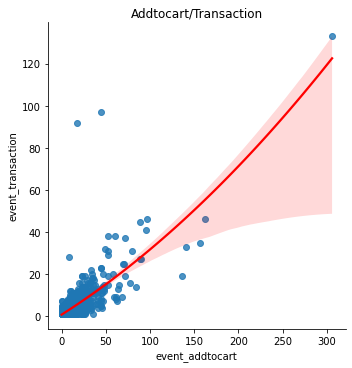

In [ ]:
#Relation entre la variable event_addcart et event_transaction
sns.lmplot(x='event_addtocart', y='event_transaction',  data=Profil_transaction, order=2, line_kws={'color': 'red'})
plt.title('Addtocart/Transaction');

Il y a une majorité de produits qui fait l'objet d'une vingtaine de transactions et qui sont vus moins de 50 fois.
Trois produits font office d'exception : un produit qui est ajouté au panier environ 300 fois et fait l'objet de 150 transactions. 
 Et 2 produits qui sont peu ajoutés au panier mais sont directement achetés.
 On pourrait considérer ces produits comme des valeurs aberrantes.

In [ ]:
## NE PAS METTRE DANS LE FINAL (car pas besoin de classe pour clustering)

# Remplacer les valeurs de la colonne Classe en données numériques pour pouvoir procéder à la standardisation

#Profil_transaction['Classe'].replace(['Faible','Moyenne','Forte'], value =[1,2,3], inplace=True)
#Profil_transaction.head(2)

### Apprentissage non supervisé avec K-Means

[[-0.24322739 -0.18806809 -0.32725009 -0.32660286]
 [11.7652701  12.11330394  9.50487596  9.93455638]
 [ 2.76408543  2.04015549  3.61950277  3.61586829]
 [ 0.59122046  0.42639816  0.9037082   0.89475441]]


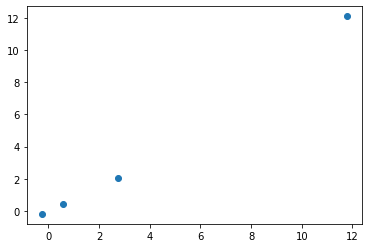

In [ ]:
# Algorithme des k-means avec n_clusters = 4

# Normalisation des données

SC = StandardScaler()
Profil_transaction_norm = SC.fit_transform(Profil_transaction)
Profil_transaction_norm

# Création d'un dataframe avec les 4 premières colonnes 
#df_kmeans=pd.DataFrame(Profil_transaction_norm[:4],columns=['event_addtocart','event_transaction','event_view','visitorid'] )


df_kmeans=pd.DataFrame(Profil_transaction_norm[:,:4], 
                       columns=['event_addtocart','event_transaction','event_view','visitorid'])
df_kmeans.head()

kmeans = KMeans(n_clusters=4)

## Ajustement 
kmeans.fit(df_kmeans)

## Prédictions
y_kmeans = kmeans.predict(df_kmeans)

y_kmeans

# Afficher les coordonnées des clusters
print(kmeans.cluster_centers_)

# représenter les coordonnées dans un graphique

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]);

**Le KMeans ressort 4 groupes de produits**. 

In [ ]:
df_kmeans.head()

,event_addtocart,event_transaction,event_view,visitorid
0,44.659899,48.380378,23.680364,26.129386
1,5.908133,35.098439,6.540486,7.356121
2,1.914630,33.253725,2.138022,2.935175
3,23.361218,16.282357,8.410814,9.715160
4,13.747231,16.282357,12.237793,12.722484


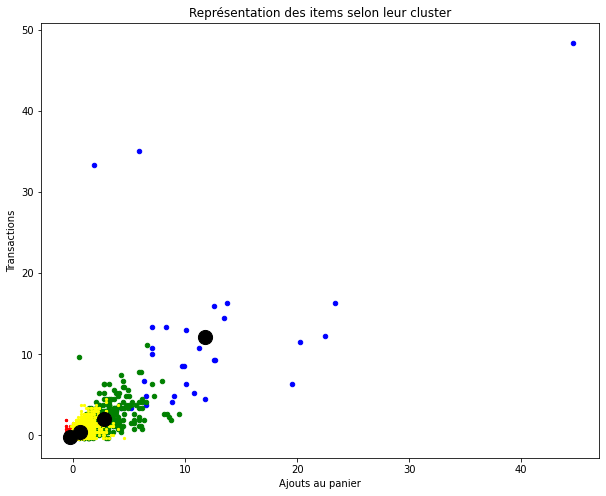

In [ ]:
#Représentation graphique de chaque item en fonction du cluster auquel il appartient

plt.figure(figsize=(10, 8))

plt.scatter(df_kmeans[y_kmeans==0].iloc[:,0], 
            df_kmeans[y_kmeans==0].iloc[:,1], 
            s=5, 
            c='red', 
            label='Cluster 1')

plt.scatter(df_kmeans[y_kmeans==1].iloc[:,0], 
            df_kmeans[y_kmeans==1].iloc[:,1],
            s=20, 
            c='blue', 
            label='Cluster 2')

plt.scatter(df_kmeans[y_kmeans==2].iloc[:,0], 
            df_kmeans[y_kmeans==2].iloc[:,1],
            s=20, 
            c='green', 
            label='Cluster 3')


plt.scatter(df_kmeans[y_kmeans==3].iloc[:,0], 
            df_kmeans[y_kmeans==3].iloc[:,1],
            s=5, 
            c='yellow', 
            label='Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1] ,c='black', s=200)
plt.xlabel('Ajouts au panier') 
plt.ylabel('Transactions')
plt.title('Représentation des items selon leur cluster');

**Vérification du cluster produit avec la méthode du coude**

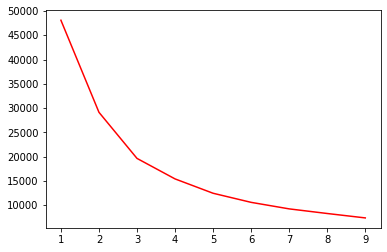

In [ ]:
# Clusterisation avec la méthode du coude

L = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_kmeans)
    L.append(kmeans.inertia_) 

fig = plt.figure()
ax = fig.add_subplot(111)    
ax.plot(range(1, 10), L, c='red');

On estime que le coude optimal = 3

In [ ]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_kmeans)
y_kmeans = kmeans.fit_predict(df_kmeans)
y_kmeans

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

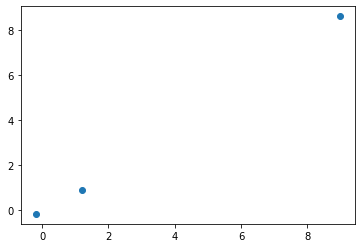

In [ ]:
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]);

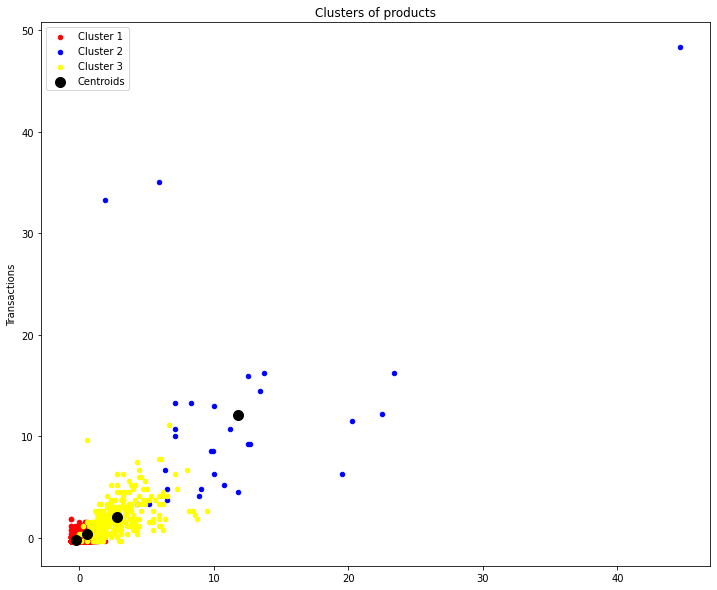

In [ ]:
plt.figure(figsize=(12, 10))

plt.scatter(df_kmeans[y_kmeans==0].iloc[:,0], df_kmeans[y_kmeans==0].iloc[:,1],
            s=20, c='red', label='Cluster 1')

plt.scatter(df_kmeans[y_kmeans==1].iloc[:,0], df_kmeans[y_kmeans==1].iloc[:,1], 
            s=20, c='blue', label='Cluster 2')

plt.scatter(df_kmeans[y_kmeans==2].iloc[:,0], df_kmeans[y_kmeans==2].iloc[:,1], 
            s=20, c='yellow', label='Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=100, c='black', label='Centroids')

plt.title('Clusters of products')
plt.ylabel('Transactions')
plt.legend(loc='best');

## **Conclusion sur le clustering des produits**

La méthode du coude donne une classification plus pertinente car elle exclue les valeurs aberrantes constatées sur 3 produits ( 461686, 119736 et 213834).

On peut donc classer les produits vendus de l'entreprise en 3 clusters disticts.selon les transactions réalisées par évènement corrélés.

# 1 bis. Clustering des produits

In [ ]:
events = pd.read_csv('events.csv')

# Décomposer la date en année, mois, jour et heure. A voir pour une exploitation future dans la table event
events['date']  = pd.to_datetime(events['timestamp'],unit='ms')
events['jour']  = pd.to_datetime(events['date']).dt.day
events['mois']  = pd.to_datetime(events['date']).dt.month
events['annee'] = pd.to_datetime(events['date']).dt.year
#events['jour_de_la_semaine']  = pd.to_datetime(events['date']).dt.day_name() # jdls : 
events['heure'] = pd.to_datetime(events['date']).dt.hour

#print(events.info())
events.head()

# Création d'un sub dataframe avec les colonnes à utiliser dans le cadre de l'hypothèse de clustering par l'heure

subevents = events[["itemid", "event","transactionid","date","heure"]]
subevents.head()

def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'aube'
    elif hour >= 7 and hour < 12:
        return 'matin'
    elif hour >= 12 and hour < 18:
        return 'apres_midi' 
    elif hour >= 18 and hour < 22:
        return 'soir'
    else:
        return 'nuit'


In [ ]:
subevents['ppj'] = events['heure'].map(get_time_periods) # la variable ppj :: periodes_par_jour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
subevents['ppj_num'] = subevents['ppj'].replace({'aube': 0, 'matin': 1, 'apres_midi': 2, 'soir': 3, 'nuit': 4})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
subevents = subevents.join(pd.get_dummies(subevents['ppj'], prefix='p'))
subevents = subevents.join(pd.get_dummies(subevents['event'], prefix='event'))

subevents.head()

,itemid,event,transactionid,date,heure,ppj,ppj_num,p_apres_midi,p_aube,p_matin,p_nuit,p_soir,event_addtocart,event_transaction,event_view
0,355908,view,NaN,2015-06-02 05:02:12.117,5,aube,0,0,1,0,0,0,0,0,1
1,248676,view,NaN,2015-06-02 05:50:14.164,5,aube,0,0,1,0,0,0,0,0,1
2,318965,view,NaN,2015-06-02 05:13:19.827,5,aube,0,0,1,0,0,0,0,0,1
3,253185,view,NaN,2015-06-02 05:12:35.914,5,aube,0,0,1,0,0,0,0,0,1
4,367447,view,NaN,2015-06-02 05:02:17.106,5,aube,0,0,1,0,0,0,0,0,1


In [ ]:
# supprimer la colonne date 
subevents = subevents.drop('date', axis = 1)

In [ ]:
# filtrer les données et afficher que les produits achétés "event_transaction = 1"

subevents_trans = subevents[subevents['event_transaction']!=0]
subevents_trans.head()

,itemid,event,transactionid,heure,ppj,ppj_num,p_apres_midi,p_aube,p_matin,p_nuit,p_soir,event_addtocart,event_transaction,event_view
130,356475,transaction,4000.0,5,aube,0,0,1,0,0,0,0,1,0
304,15335,transaction,11117.0,21,soir,3,0,0,0,0,1,0,1,0
418,81345,transaction,5444.0,21,soir,3,0,0,0,0,1,0,1,0
814,150318,transaction,13556.0,16,apres_midi,2,1,0,0,0,0,0,1,0
843,310791,transaction,7244.0,16,apres_midi,2,1,0,0,0,0,0,1,0


In [ ]:
# Verifier au global le nombre des item_trans en appliquant groupby periodes_par_jour: 
data = pd.DataFrame(subevents_trans.groupby(['ppj'])['transactionid'].count()).reset_index()
data

,ppj,transactionid
0,apres_midi,5532
1,aube,2807
2,matin,595
3,nuit,6079
4,soir,7444


In [ ]:
# Grouper les données par item - 
# L'aggrégation par type d'évènement n'est plus nécessaire puisque nous n'avons filtré que sur les transactions

df = subevents_trans.groupby('itemid').agg({ 
                                  'event_transaction': 'count',
                                  'p_aube': 'sum', 
                                  'p_matin': 'sum',
                                  'p_apres_midi': 'sum',
                                  'p_soir': 'sum',
                                  'p_nuit': 'sum'}).astype('int').sort_values(by='event_transaction', ascending=False)

In [ ]:
df['freq_aube'] = (df['p_aube'] / df['event_transaction'] *100).round(2)
df['freq_matin'] = (df['p_matin'] / df['event_transaction'] *100).round(2)
df['freq_apres_midi'] = (df['p_apres_midi'] / df['event_transaction'] *100).round(2)
df['freq_soir'] = (df['p_soir'] / df['event_transaction'] *100).round(2)
df['freq_nuit'] = (df['p_nuit'] / df['event_transaction'] *100).round(2)

df.head()

,event_transaction,p_aube,p_matin,p_apres_midi,p_soir,p_nuit,freq_aube,freq_matin,freq_apres_midi,freq_soir,freq_nuit
itemid,,,,,,,,,,,
461686,133,35,8,24,36,30,26.32,6.02,18.05,27.07,22.56
119736,97,0,0,29,39,29,0.00,0.00,29.90,40.21,29.90
213834,92,17,2,23,19,31,18.48,2.17,25.00,20.65,33.70
312728,46,4,3,13,10,16,8.70,6.52,28.26,21.74,34.78
7943,46,11,0,11,15,9,23.91,0.00,23.91,32.61,19.57


In [ ]:
df = df.drop(['p_aube', 'p_matin', 'p_apres_midi', 'p_soir', 'p_nuit'], axis=1)
df.head()

,event_transaction,freq_aube,freq_matin,freq_apres_midi,freq_soir,freq_nuit
itemid,,,,,,
461686,133,26.32,6.02,18.05,27.07,22.56
119736,97,0.00,0.00,29.90,40.21,29.90
213834,92,18.48,2.17,25.00,20.65,33.70
312728,46,8.70,6.52,28.26,21.74,34.78
7943,46,23.91,0.00,23.91,32.61,19.57


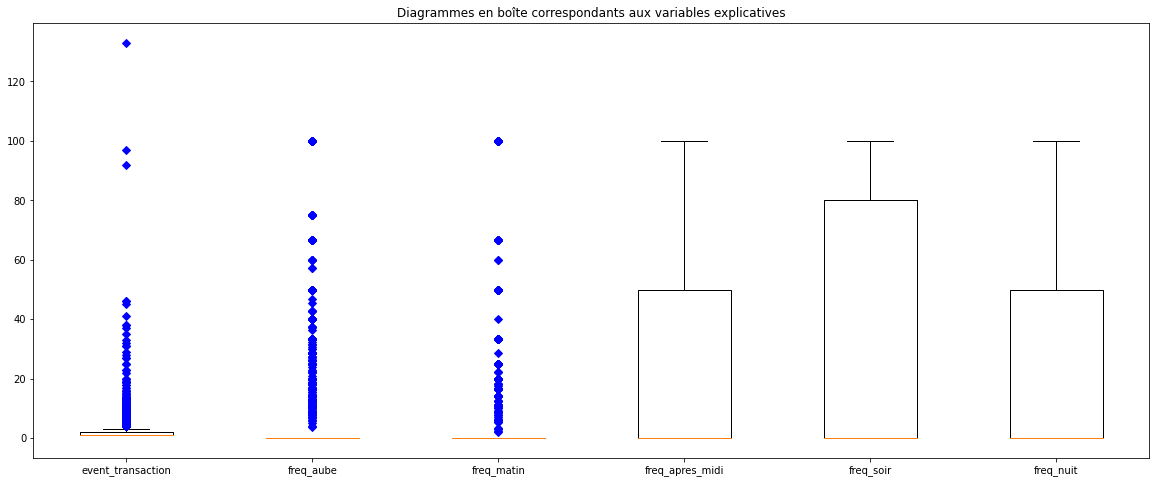

In [ ]:
# Détection des valeurs aberrantes en tracant les boîtes à moustaches pour chacune des variables explicatives

plt.figure(figsize= (20,8))
plt.title('Diagrammes en boîte correspondants aux variables explicatives')
plt.boxplot(df.values, 0, 'bD', labels = df.keys())
plt.show()

# on a 3 valeurs extrement aberrantes : les 3 produits les plus achetés (cf visualisations précédentes)

In [ ]:
from sklearn.cluster import KMeans 

kmeans = KMeans(n_clusters = 3) 
kmeans.fit(df)
y_kmeans = kmeans.predict(df)

# Centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))
print('labels sans doublons : ', list(set(labels)))

12025
labels sans doublons :  [0, 1, 2]


In [ ]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

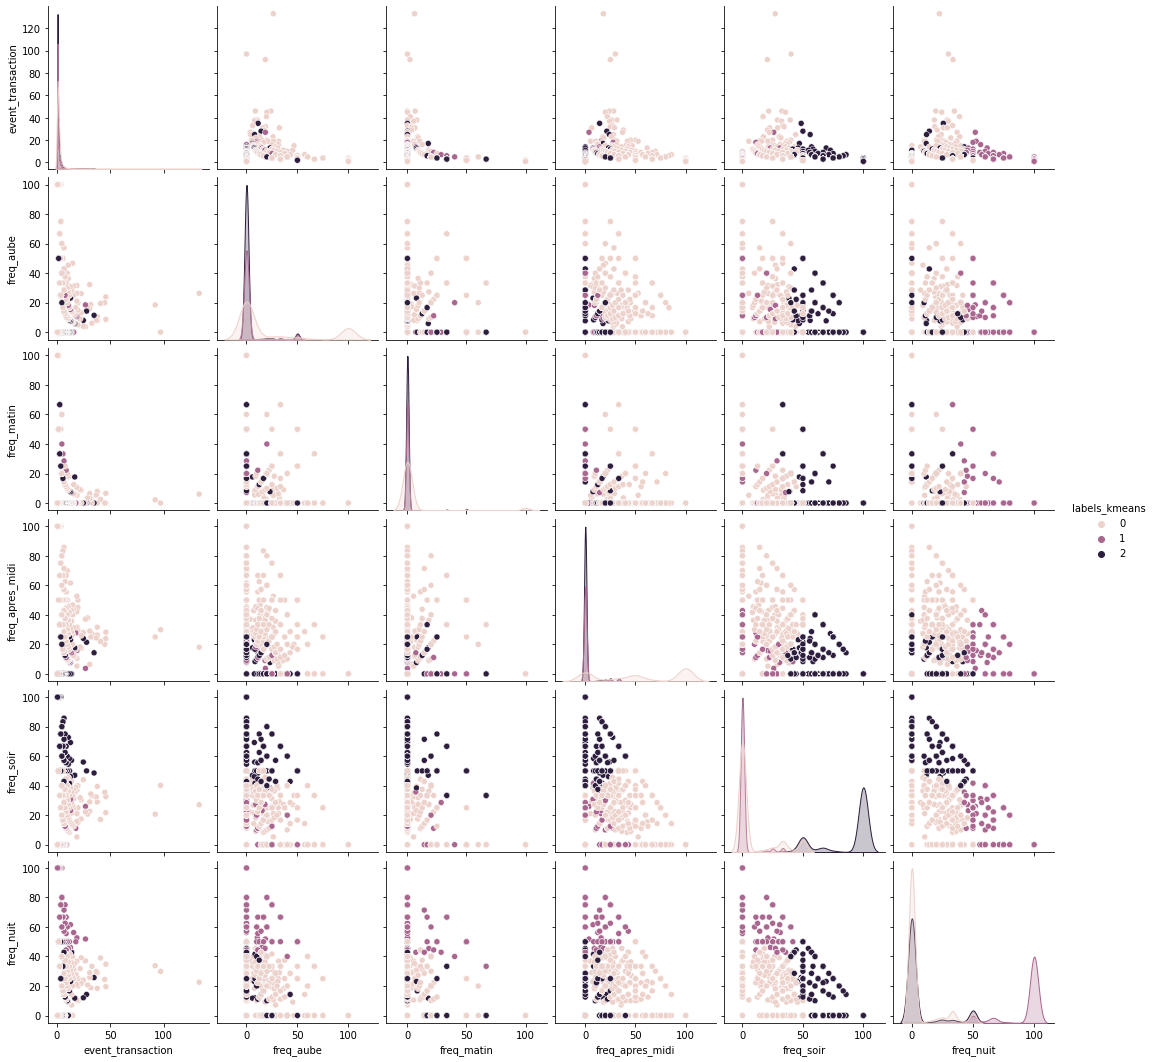

In [ ]:
# on fait un pairplot des items colorié en fonction du cluster attribué
D = df.copy()
D['labels_kmeans'] = kmeans.labels_
sns.pairplot(D, hue='labels_kmeans');

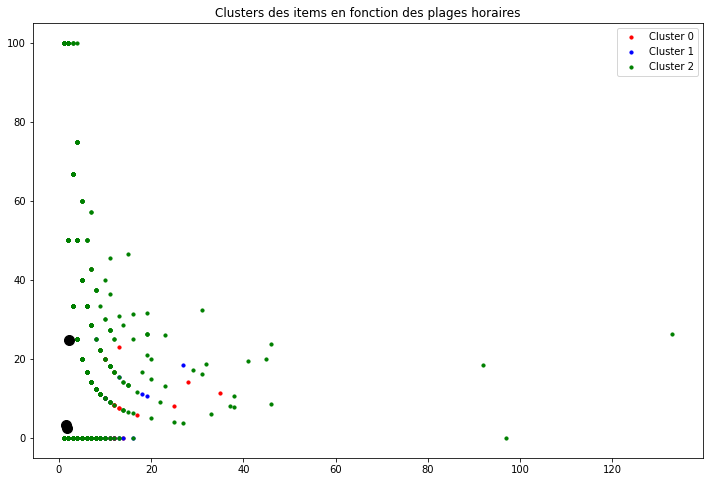

In [ ]:
# Graphs views
plt.figure(figsize=(12, 8))

plt.scatter(df[y_kmeans==0].iloc[:,0], df[y_kmeans==0].iloc[:,1],  # individus Cluster 0
            s=10, c='red', label='Cluster 0')

plt.scatter(df[y_kmeans==1].iloc[:,0], df[y_kmeans==1].iloc[:,1],  # individus Cluster 1
            s=10, c='blue', label='Cluster 1')

plt.scatter(df[y_kmeans==2].iloc[:,0], df[y_kmeans==2].iloc[:,1],  # individus Cluster 2
            s=10, c='green', label='Cluster 2')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s=100)   # coordonéés

plt.legend()
plt.title('Clusters des items en fonction des plages horaires');

# 2. Clustering des visiteurs

### Ré importation de events (masqué)

In [ ]:
# import data events only 
events = pd.read_csv('events.csv')
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [ ]:
# on refait la transfo de la date 
events['date'] = pd.to_datetime(events['timestamp'],unit='ms')
events['year']=pd.to_datetime(events['date']).dt.year
events['month']=pd.to_datetime(events['date']).dt.month
events['day']=pd.to_datetime(events['date']).dt.day
events['time']=pd.to_datetime(events['date']).dt.time

### Modélisation K-Means

In [ ]:
# On garde uniquement les colonnes qui nous intéressent pour le clustering (visitor / item / type d'event)
df_e = events.drop(['timestamp', 'transactionid', 'date', 'year', 'month', 'day', 'time'], axis=1)
df_e.head()

,visitorid,event,itemid
0,257597,view,355908
1,992329,view,248676
2,111016,view,318965
3,483717,view,253185
4,951259,view,367447


In [ ]:
# Dichotomisation de la variable catégorielle event afin d'avoir 0 ou 1 pour chaque type d'event
df_e = df_e.join(pd.get_dummies(df_e['event'], prefix='event'))

In [ ]:
# On groupe par visitorid avec la somme de tous les event (prend quelques minutes)
df_visitor = df_e.groupby('visitorid').agg({'event_view':'sum',
                                            'event_addtocart':'sum',
                                            'event_transaction':'sum'})
df_visitor.head()

,event_view,event_addtocart,event_transaction
visitorid,,,
0,3.0,0.0,0.0
1,1.0,0.0,0.0
2,8.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
# On garde le df_visitor et on utilise df pour la modélisation afin de repartir d'ici si nécessaire
df = df_visitor.drop('event_addtocart', axis=1)
df.head()

,event_view,event_transaction
visitorid,,
0,3.0,0.0
1,1.0,0.0
2,8.0,0.0
3,1.0,0.0
4,1.0,0.0


In [ ]:
# Standardisation du df 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

SC = StandardScaler()
Z = SC.fit_transform(df)

# Création du df_kmeans normalisé
df_kmeans = pd.DataFrame(Z, columns=['Nombre de visites', 'Nombre de transactions'])

In [ ]:
# Modélisation avec 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_kmeans)
y_kmeans = kmeans.predict(df_kmeans)

print(' Coordonnées cluster 0:', kmeans.cluster_centers_[0],'\n',
      'Coordonnées cluster 1:', kmeans.cluster_centers_[1], '\n',
      'Coordonnées cluster 2:', kmeans.cluster_centers_[2])

 Coordonnées cluster 0: [-0.00448458 -0.00400873] 
 Coordonnées cluster 1: [99.69627799 80.71312541] 
 Coordonnées cluster 2: [375.98290294 481.76804178]


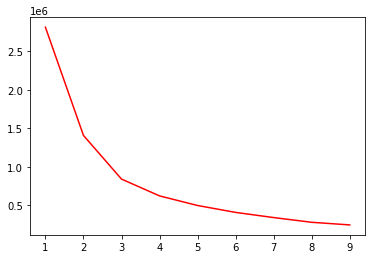

In [ ]:
## Méthode du coude pour voir combien de clusters on choisit 
L = []

for i in range(1,10):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_kmeans)
    L.append(kmeans.inertia_) 

fig = plt.figure()
ax = fig.add_subplot(111)    
ax.plot(range(1, 10), L, c='red');

Le choix entre n_clusters = 2 ou 3 est assez flou car la cassure sur le graphique semble similaire pour les 2 valeurs. Néanmoins, nous allons choisir de regrouper les inidividus en **3 clusters**, car 2 clusters nous semble peu au vu du nombre de visiteurs. 

In [ ]:
from collections import Counter
print(dict(Counter(kmeans.labels_)))

{0: 1407525, 2: 52, 1: 3}


Nous avons donc 3 clusters, avec les centroïdes représentés par les points noirs (ci-dessous), qui sont :
- 1407525 visiteurs dans le premier cluster (rouge)
- 52 visiteurs dans le deuxième cluster (vert)
- et 3 dans le 3ème cluster (bleu)

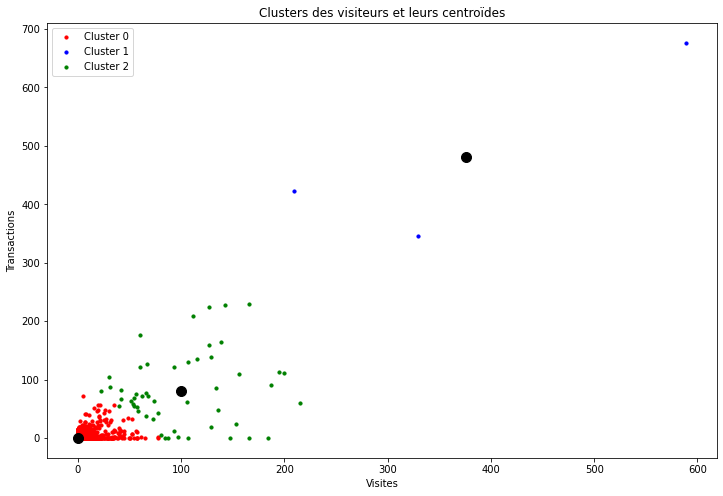

In [ ]:
# Graphique des clusters pour n_clusters=3

plt.figure(figsize=(12, 8))

plt.scatter(df_kmeans[y_kmeans==0].iloc[:,0], df_kmeans[y_kmeans==0].iloc[:,1],  # individus Cluster 0
            s=10, c='red', label='Cluster 0')

plt.scatter(df_kmeans[y_kmeans==1].iloc[:,0], df_kmeans[y_kmeans==1].iloc[:,1],  # individus Cluster 1
            s=10, c='blue', label='Cluster 1')

plt.scatter(df_kmeans[y_kmeans==2].iloc[:,0], df_kmeans[y_kmeans==2].iloc[:,1],  # individus Cluster 2
            s=10, c='green', label='Cluster 2')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s=100)   # coordonéés

plt.xlabel('Visites') 
plt.ylabel('Transactions')
plt.legend()
plt.title('Clusters des visiteurs et leurs centroïdes');

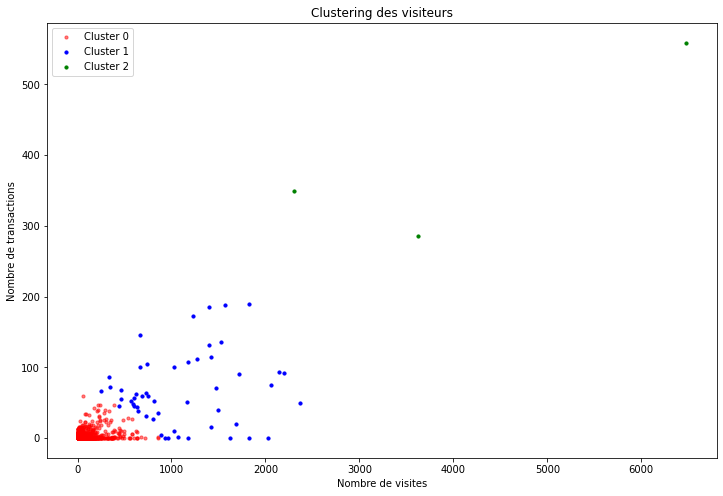

In [ ]:
# Graphique avec le df non standardisé pour avoir les bons ordres de grandeur 
plt.figure(figsize=(12, 8))

plt.scatter(df[y_kmeans==0].iloc[:,0], df[y_kmeans==0].iloc[:,1],  # individus Cluster 0
            s=10, c='red', alpha = 0.5, label='Cluster 0')

plt.scatter(df[y_kmeans==1].iloc[:,0], df[y_kmeans==1].iloc[:,1],  # individus Cluster 1
            s=10, c='blue', label='Cluster 1')

plt.scatter(df[y_kmeans==2].iloc[:,0], df[y_kmeans==2].iloc[:,1],  # individus Cluster 2
            s=10, c='green', label='Cluster 2')

plt.xlabel('Nombre de visites') 
plt.ylabel('Nombre de transactions')
plt.legend()
plt.title('Clustering des visiteurs');

Sur le graphique ci-dessus, on voit que la standardisation des données nous a permis de créer des clusters cohérents:
- le premier regroupe les visiteurs ayant fait environ moins de 900 visites, et moins de 800 transactions
- le deuxième cluster regroupe les clients ayant fait moins de 2500 visites et moins de 2000 transactions
- le dernier regroupe les Top clients qui font beaucoup de visites et beaucoup de transactions, à savoir, plus de 2500 visites et plus de 2500 transactions

Nous avons ici 3 clusters créés en fonction de ces deux variables. Les limites de ce modèle seraient de ne pas différencier les clients par exemple ayant fait beaucoup de visites mais très peu de commandes.

Nous pouvons essayer un clustering en 5 clusters afin de voir comment le modèle peut nous servir à segmenter encore un peu les visiteurs. 

In [ ]:
# Modélisation avec 5 clusters pour plus de segmentation

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_kmeans)
y_kmeans = kmeans.predict(df_kmeans)

print(' Coordonnées cluster 0:', kmeans.cluster_centers_[0],'\n',
      'Coordonnées cluster 1:', kmeans.cluster_centers_[1], '\n',
      'Coordonnées cluster 2:', kmeans.cluster_centers_[2], '\n',
      'Coordonnées cluster 3:', kmeans.cluster_centers_[3],'\n',
      'Coordonnées cluster 4:', kmeans.cluster_centers_[4], '\n',)

 Coordonnées cluster 0: [-0.00649741 -0.00484735] 
 Coordonnées cluster 1: [269.39148152 384.32110192] 
 Coordonnées cluster 2: [50.78044203 24.47131998] 
 Coordonnées cluster 3: [133.29191237 143.90526174] 
 Coordonnées cluster 4: [589.16574578 676.6619215 ] 



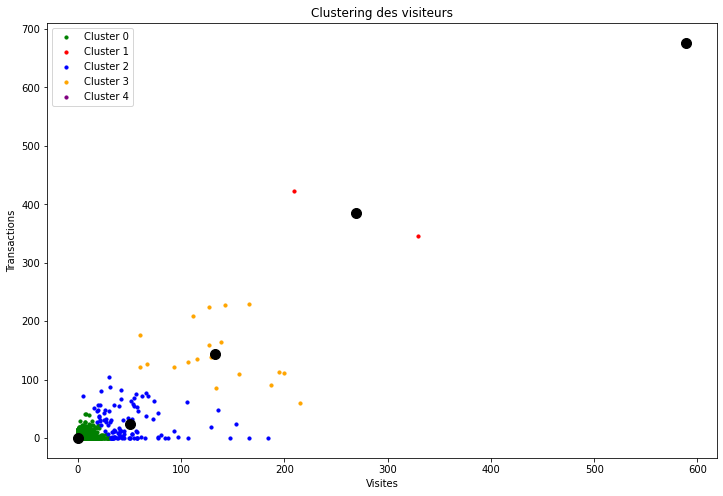

In [ ]:
# Graphique clustering pour n_clusters=5

plt.figure(figsize=(12, 8))

plt.scatter(df_kmeans[y_kmeans==0].iloc[:,0], df_kmeans[y_kmeans==0].iloc[:,1],  # individus Cluster 0
            s=10, c='green', label='Cluster 0')

plt.scatter(df_kmeans[y_kmeans==1].iloc[:,0], df_kmeans[y_kmeans==1].iloc[:,1],  # individus Cluster 1
            s=10, c='red', label='Cluster 1')

plt.scatter(df_kmeans[y_kmeans==2].iloc[:,0], df_kmeans[y_kmeans==2].iloc[:,1],  # individus Cluster 2
            s=10, c='blue', label='Cluster 2')

plt.scatter(df_kmeans[y_kmeans==3].iloc[:,0], df_kmeans[y_kmeans==3].iloc[:,1],  # individus Cluster 3
            s=10, c='orange', label='Cluster 3')

plt.scatter(df_kmeans[y_kmeans==4].iloc[:,0], df_kmeans[y_kmeans==4].iloc[:,1],  # individus Cluster 4
            s=10, c='purple', label='Cluster 4')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', s=100)   # centroïdes

plt.xlabel('Visites') 
plt.ylabel('Transactions')
plt.legend()
plt.title('Clustering des visiteurs');

**Conclusion du clustering visiteurs**

Ajouter des clusters n'est pas vraiment utile ici puisque le modèle sépare les clusters ayant déjà très peu de visiteurs et non pas la "masse" de visiteurs de plus d'un millions de clients. Nous garderons le clustering à 3 clusters.

On peut penser également à ensuite, diviser ces clusters en deux afin de garder dans chaque classe, ceux qui ont peu de visites (que l'on pourrait catégoriser comme acheteur rapides/compulsifs/réguliers), et les visiteurs ayant beaucoup de visites pour un même nombre d'achats (nouveaux clients, plus longs à la prise de décision etc).

# 3. Modèle de prédiction d'achat : feature engineering

In [ ]:
events = pd.read_csv('events.csv')

import datetime
times =[]
for i in events['timestamp']:
    times.append(datetime.datetime.fromtimestamp(i//1000.0)) 
events['timestamp'] = times

# Impossible d attribuer timestamp à une colonne lorsqu'il est sous format yyyy/mm/dd h/m/s
# On convertit les timestamp en seconde avec T0=premier timestamp du tableau
events['time_t0'] = (events['timestamp'] - events['timestamp'].min())  / np.timedelta64(1,'s')

# Création de la colonne visitorid_itemid
events['visitorid']=events['visitorid'].astype(str)
events['itemid']=events['itemid'].astype(str)
events['visitorid_itemid']=events['visitorid']+" ; "+events['itemid']

# Tri par date (pas nécessaire)
events = events.sort_values('timestamp')

# Création des features_date pour récupérer les dates pour chaque type d'event
events['view_date'] = np.where(events['event']=='view', events['time_t0'], np.nan)
events['add_date'] = np.where(events['event']=='addtocart', events['time_t0'], np.nan)

# Création d'un dataframe qui pour chaque couple visitorid_itemid indique la première date de vue / mise au panier / achat
df_view = (events.groupby(['visitorid_itemid'])
                    .agg({'view_date':'min'})
                    .rename(columns={'min':'view#1'})).reset_index()

df_add = (events.groupby(['visitorid_itemid'])
                    .agg({'add_date':'min'})
                    .rename(columns={'min':'add#1'})).reset_index()

df_date=df_view.merge(right = df_add, on = 'visitorid_itemid', how = 'outer')

# Création d'une colonne qui calcule le temps entre la première vue & l'achat du produit en secondes
df_date['delta_view_add']=(df_date['add_date']-df_date['view_date'])

# On sépare item & visiteur
df_date[['visitorid','itemid']] = df_date['visitorid_itemid'].str.split(' ; ', expand=True)

# On remet dans l'ordre, en supprimant la colonne visitor_item 
df_date = df_date[['visitorid', 'itemid', 'view_date', 'add_date', 'delta_view_add']]



In [ ]:
# On construit le tableau df_visitor qui montrera les deltas de temps moyens passés par chaque visiteurs
df_view_add = (df_date.groupby(['visitorid']).agg({'delta_view_add':'mean'}))

# On va supprimer les valeurs négatives pour les deltas (actions qui ont eu lieu par la suite)
view_add_negatif=df_view_add[df_view_add['delta_view_add']<0].index
df_view_add=df_view_add.drop(view_add_negatif)

# On supprime les lignes pour lesquels tous les delta sont manquants
df_view_add=df_view_add.dropna(axis = 0, how = 'all', subset = ['delta_view_add'])


In [ ]:
df_view_add=df_view_add.reset_index()

In [ ]:
df_view_add

,visitorid,delta_view_add
0,1000057,2418.0
1,1000093,135.0
2,1000103,71.0
3,100012,5.0
4,1000169,29.0
...,...,...
29615,999895,92.0
29616,999926,792.0
29617,999959,231.0
29618,999986,243.0


L'exécution de la cellule suivante prend environ 30-50 minutes 

In [ ]:
# Créer une fonction pour compter le nb de visites / items vus / achats pour un visitorID
def décompte(visiteurs):
    
    df_array = []
    for index in visiteurs:

        # On crée un DF temporaire avec n° ligne = visiteurs
        df_temporaire = events[events.visitorid == index]

        temp = []
        # On ajoute à chaque fois l'ID visitor
        temp.append(index)

        # Décompte produits uniques vus
        temp.append(df_temporaire[df_temporaire.event == 'view'].itemid.unique().size)

        # Décompte de vues/visites (tout objet confondu)
        temp.append(df_temporaire[df_temporaire.event == 'view'].event.count())

        # Décompte nb achats
        nombre_item_achetés = df_temporaire[df_temporaire.event == 'transaction'].event.count()
        temp.append(nombre_item_achetés)

        # Ajout d'un 0/1 si achat ou pas achat
        if(nombre_item_achetés == 0):
            temp.append(0)
        else:
            temp.append(1)

        df_array.append(temp)
    
    return pd.DataFrame(df_array, columns=['visitorid', 'nb_items_vus', 'nb_vues', 'nb_achats', 'a acheté'])

# Liste de tous les visiteurs du tableau df_view_add
visiteurs = df_view_add.visitorid.unique()
# On prend cette liste visiteurs et on compte leur nombres de vues, d'items vus, d'achats et s'ils ont acheté
df_décompte = décompte(visiteurs)


In [ ]:
df_view_add['visitorid']=df_view_add['visitorid'].astype('int64')
df_décompte['visitorid']=df_décompte['visitorid'].astype('int64')

In [ ]:
# On fusionne les tableaux df_décompte & df_visitor pour récupérer toutes les features qui nous intéressent
df_visites=df_view_add.merge(right = df_décompte, on = 'visitorid', how = 'inner')

# On supprime les doublons (certaines lignes avec le même visitorId & les mêmes infos ont été doublées lors du merge)
df_visites=df_visites.drop_duplicates(subset = ['visitorid'], keep = 'first')

# Pour pouvoir utiliser un modèle sur nos données, on va devoir supprimer les données manquantes qui sont dans delta_view_add (quand le visiteur n'a pas visité le produit avant de l'ajouter à son panier)
df_visites=df_visites.dropna(axis = 0, how = 'all', subset = ['delta_view_add'])
df_visites

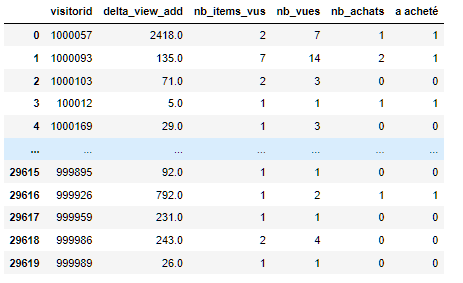

# 3. Modèle de prédiction d'achat : Régression Logistique

In [ ]:
# On sépare variables descriptives (nb visites & nb items vus & delta view_add) & la target (l'acte d achat)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = df_visites.drop(['visitorid', 'nb_achats', 'a acheté'], axis = 'columns')
y = df_visites['a acheté']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021, train_size = 0.7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Vu la projection, on va essayer d'abord une LR
reg = LogisticRegression()
reg.fit(X_train, y_train)

# Afficher taux de bonnes prédictions sur du modèle sur l'ensemble d'entraînement et l'ensemble test
train_acc = accuracy_score(y_true=y_train, y_pred=reg.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=reg.predict(X_test))

print(train_acc)
print(test_acc)

Accuracy scores : 0,68 et 0,69

Ayant un doute sur l'importance de la feature "delta_view_add" pour prédire l'achat (si la personne a ajouté un produit à son pannier, que cela soit lent ou rapide, sa décision est normalement quasi prise : elle devrait l'acheter), nous allons vérifier ça en deux temps: avec une partie feature selection (ci-dessous) puis en refaisant la RL en ne prenant en compte que les features nombre de visites & nombre de produits vus 

In [ ]:
from sklearn.feature_selection import SelectKBest,
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

sel = SelectKBest(score_func = f_regression, k=2)
sel.fit(X_train, y_train)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [ ]:
# On refait la même chose en excluant la variable delta view_add
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = df_visites.drop(['visitorid', 'nb_achats', 'a acheté', 'delta_view_add'], axis = 'columns')
y = df_visites['a acheté']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2021, train_size = 0.7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Vu la projection, on va essayer d'abord une LR
reg = LogisticRegression()
reg.fit(X_train, y_train)

# Afficher taux de bonnes prédictions sur du modèle sur l'ensemble d'entraînement et l'ensemble test
train_acc = accuracy_score(y_true=y_train, y_pred=reg.predict(X_train))
test_acc = accuracy_score(y_true=y_test, y_pred=reg.predict(X_test))

print(train_acc)
print(test_acc)

L'accuracy score est identique

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Courbe hasard (50%)
fauxpositif, vraipositif, _ = roc_curve(y_test, [0 for _ in range(len(y_test))])
# Courbe avec notre modèle
fauxpositif2, vraipositif2, _ = roc_curve(y_test, reg.predict(X_test))
pyplot.plot(fauxpositif, vraipositif, linestyle='--', label='Hasard')
pyplot.plot(fauxpositif2, vraipositif2, marker='.', label='Modèle')
pyplot.xlabel('Faux positif')
pyplot.ylabel('Vrai positif')
pyplot.legend()
pyplot.show()

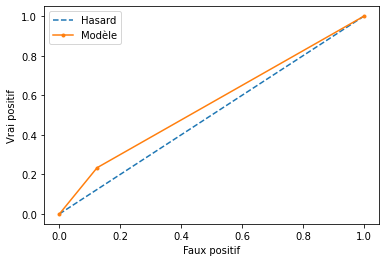

# 3. Modèle de prédiction d'achat : SVM

In [ ]:
from sklearn import SVC
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = df_visites.drop(['visitorid', 'nb_achats', 'a acheté'], axis = 'columns')
y = df_visites['a acheté']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, train_size = 0.7)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(gamma='scale')
svm.fit(X_train, y_train)

print('Score sur ensemble test', svm.score(X_test, y_test))

In [ ]:
y_pred = svm.predict(X_test)

print(pd.crosstab(y_test, y_pred, colnames=['Predictions']))

Accuracy score : 0,69

# 3. Modèle de prédiction d'achat : K plus proches voisins

In [ ]:
# Import des bibliothèques nécessaires
from sklearn import neighbors
from sklearn import datasets
from sklearn.model_selection import train_test_split


X = df_visites.drop(['visitorid', 'nb_achats', 'a acheté'], axis = 'columns')
y = df_visites['a acheté']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=50, train_size = 0.7)

# Création du classifieur et construction du modèle sur les données d'entraînement
# n_neigbors a été choisi grâce à la cellule suivante
knn = neighbors.KNeighborsClassifier(n_neighbors=30, metric='minkowski')
knn.fit(X_train, y_train)

# Appliquer modèle aux données test & stocker prédictions
y_pred = knn.predict(X_test)
# Afficher matrice de confusion pour comparer classes réelles & prédites
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

#Score du modèle utilisant la distance de Minkowski
score_minkowski = knn.score(X_test, y_test)


In [ ]:
## Pour confirmer le n_neighbors à prendre, on peut éxécuter la cellule suivante
for k in range(1, 40):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    score_minko.append(knn.score(X_test, y_test))

# Afficher dans un graphique les listes créées en fonction de la valeur de k.
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(1, 40), score_minko, color='blue', linestyle='dashed', lw=2, label='Minkowski')
plt.title('Score - valeur de K')  
plt.xlabel('Valeur de K')  
plt.ylabel('Accuracy') 
plt.legend();

Accuracy score à 0,65

# 3. Modèle de prédiction d'achat : meilleur modèle

Le meilleur résultat est obtenu avec l'algorithme LR et SVM (0,69) et la méthode des K plus proches voisins (0,65)